In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net import create_train_state, train, neural_ode
from collocation import compute_weights, lagrange_derivative

In [3]:
#-----------------------------------------------VARYING NOISE LEVELS-----------------------------------------------#
N = 20
noise_level = 0.0
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=5
spacing_type="chebyshev"
initial_state = 1.0

t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [4]:
jax.config.update("jax_enable_x64", True)

In [5]:
#-----------------------------------------------SIMPLE ODE DEF-----------------------------------------------#
def ode_func(t, u):
    # du_dt = -u
    return -u

#-----------------------------------------------L and L_prime-----------------------------------------------#
L = jnp.eye(N)
weights = compute_weights(t)
L_prime = lagrange_derivative(t, weights)

In [6]:
#-----------------------------------------------F(u) and G(u)-----------------------------------------------#
def RHS(u, t, L, ode_func):
    def F_i(i):
        sum_term = jnp.dot(u, L[i])  # Lagrange interpolation
        return ode_func(t[i], sum_term)
    
    F_vec = jax.vmap(F_i)(jnp.arange(N))
    return F_vec

def G(u, t, L, L_prime, RHS, ode_func):
    return jnp.dot(L_prime, u) - RHS(u, t, L, ode_func)

In [7]:
RHS(y, t, L, ode_func)*-1

G(y, t, L, L_prime, RHS, ode_func)

Array([-8.21819270e-07,  4.43138401e-07,  2.01005101e-08, -2.07512204e-08,
        3.29986478e-08, -2.03982620e-08,  1.60198929e-08, -2.07840439e-10,
        6.56420998e-09, -9.29522906e-09,  1.71525569e-08,  3.09863461e-09,
       -6.15849597e-10, -1.77931449e-09,  9.09786430e-09, -1.21459575e-08,
        2.08409280e-08, -6.75222382e-09, -2.77581852e-08, -9.49552729e-08],      dtype=float64)

In [8]:
#-------------------------------------SOLVE USING OPTIMIZATION---------------------------------------------#
def loss_fn(u, t, L, L_prime, RHS, ode_func):
    G_val = G(u, t, L, L_prime, RHS, ode_func)
    return jnp.sum(G_val**2)

def optimize(u_init, t, L, L_prime, RHS, ode_func, learning_rate=1e-1, tol=1e-6, max_iter=10000):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(u_init)

    @jax.jit
    def step(u, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(u, t, L, L_prime, RHS, ode_func)
        updates, opt_state = optimizer.update(grads, opt_state)
        u = optax.apply_updates(u, updates)
        return u, opt_state, loss

    u = u_init
    for i in range(max_iter):
        u, opt_state, loss = step(u, opt_state)
        if loss < tol:
            print(f"Converged at iteration {i+1} with loss {loss}")
            return u
    
    raise ValueError("Optimization did not converge")

# initial guess for u
u_init = jnp.ones(N)
u_init = u_init.at[0].set(1.0)  # initial condition u(0) = u0

t1 = time.time()
u_sol = optimize(u_init, t, L, L_prime, RHS, ode_func)
t2 = time.time()
print(f"Time elapsed: {t2 - t1}")

Converged at iteration 1141 with loss 9.859159009117482e-07
Time elapsed: 0.08851885795593262


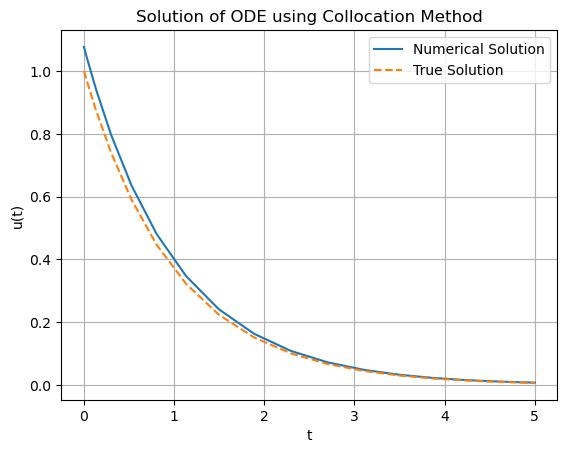

In [11]:
# Plot the solution
plt.plot(t, u_sol, label='Numerical Solution')
plt.plot(t, y, "--", label='True Solution')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()

In [73]:
def f_2(t, uv, omega):
    u, v = uv
    return jnp.array([v, -omega**2 * u])

In [74]:
uv_init = jnp.ones((N, 2)) 
# initial velocity to 0
uv_init = uv_init.at[0, 1].set(0)  
u0=jnp.array([1.0, 0.0])

t1 = time.time()
u_sol = optimize(uv_init, t, L, L_prime, RHS, f_2)
t2 = time.time()
print(f"Time elapsed: {t2 - t1}")

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (25,).